In [1]:
#Use this line to set the number of  CPU used for execution of the program (if it's not working, use the commented line:
#see https://stackoverflow.com/questions/17053671/python-how-do-you-stop-numpy-from-multithreading/21673595 for more information)

import os

os.environ['OPENBLAS_NUM_THREADS'] = '5' 
os.environ['MKL_NUM_THREADS'] = '5'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Low rank VAR(1) Simulation

The main goal of this notebook is to implement and to test the low_rank VAR(1) algorithm. In order to do so, we will:
- generate data according to a low-rank high dimensionnal VAR(1) process
- implement the estimation of the low rank VAR(1) models
- compare this model with a standard VAR(1) among differents  features


We want to simulate an VAR(1) processus generated by a matrix A of rank r. We consider the time series $(X_t) \in \mathbb{R}^M$ of length generated by 

$$ X_{t+1} = A X_t + \epsilon_t   $$
    
where $\epsilon_t \sim \mathcal{N}(0,\sigma^{2})\$ 


## I Generation


In order to generate A, we use the following procedure:

- We uniformly generate U and V matrices of respective shape $M\times r$ and $r \times M$. 
- We transform U and V using Gram-Schmdit otrhonomalization
- We generate $\lambda_1,\dots\lambda_r$ r singular values according to a $\mathcal{\beta}(a,1)$ distribution
- We take $A = U diag(\lambda_1, \dots, \lambda_r) V^T$

In [73]:
def random_unit_matrix(M,P):
    """Generation of a MxP unit matrices using Gram Schmidt Orthonormalization"""
    list_col = [ np.random.uniform(low = - 1, size = M) for i in range(P)]
    
    new_list_col = list()
    for  col in list_col:
        new_col = col
        for old_col in new_list_col:
            new_col -= old_col.dot(col) * old_col
        new_col = new_col/np.linalg.norm(new_col)
        new_list_col.append(new_col)
    
    list_col = [col.reshape(M,1) for col in new_list_col]
    
    return np.concatenate(list_col , axis = 1)


def generate_matrix(M, r, a) : 
    U = random_unit_matrix(M,r)
    V = random_unit_matrix(M,r).transpose()
    diag = np.diag(np.random.beta(a,1, size =r))
    A =  U.dot(diag.dot(V))
    return A

def tronc_gaussian(sigma, limit = 1):
    """Truncated centred gaussian distribution with deviation sigma"""
    ret = np.random.normal(scale = sigma)
    if abs(ret) > limit:
        return tronc_gaussian(sigma, limit=limit)
    return ret

def vect_tronc_gaussian(n,m, sigma = 1, limit = 1):
    A = np.array([tronc_gaussian(sigma, limit=limit) for i in range(n*m)])
    return A.reshape((n,m))

def generate_series(A,n,sigma= 1, limit_gaussian = 1 ):
    M = A.shape[0]
    cur =  vect_tronc_gaussian(M,1,sigma= sigma, limit=limit_gaussian)
    list_vect = [cur]
    for i in range(n-1):
        cur = A.dot(cur) + vect_tronc_gaussian(M,1,sigma=sigma, limit=limit_gaussian)
        list_vect.append(cur)
    return np.concatenate(list_vect, axis = 1)
    


##  II Three estimators

### II.A Benchmark : Full Rank Estimator

To compare the performance of our model, we use the standard VAR(1) estimator $\widehat{A}_{std}$ defined as :

$$ \widehat{A}_{std}  =\underset{A \in \mathcal{M}_{M \times M }(\mathbb{R})}{argmin} \sum_{i=0}^n \|X_{i+1} - A X_i \|_2^2 $$ 

If we set :

$$ Y = \left(X_1| X_2 | \dots | X_n \right)$$
$$ X = \left(X_0|X_1 | \dots | X_{n-1} \right)$$

We have then 

$$  \widehat{A}_{std} = \underset{A \in \mathcal{M}_{M \times M }(\mathbb{R})}{argmin} \|Y- AX \|_F^2 $$

where $\|\|_F$ is the Frobenius norm. Therefore, we can have an exact expression for $\widehat{A}_{std}$:
$$\widehat{A}_{std} = (X X^T)^{-1} X^T Y$$


In [4]:
def empirical_risk(estim,series ):
    """Empirical Squared L2 risk for a matrix estim"""
    n = series.shape[1]-1 
    return( 1/n * sum([np.linalg.norm(series[:,i+1] - estim @ series[:,i])**2  for i in range(n)]) ) 

def std_estimator(series):
    """ Full rank estimator"""
    Y = series[:,1:]
    X = series[:,:-1]
    return  (Y @ X.transpose()) @  np.linalg.inv(X@ X.transpose() ) 

### II.B Low Rank Estimator

In this setting, we perform the minimization describe in the paper 

$$ \widehat{U}_{low rank}, \widehat{V}_{low rank}  =\underset{U,V \in \mathcal{M}_{M \times r }(\mathbb{R})}{argmin} \sum_{i=0}^n \|X_{i+1} - U V^T X_i \|_2^2 $$ 

And we have then $\widehat{A}_{low rank} = \widehat{U}_{low rank} \widehat{V}_{low rank} $

To perform this minimization, we alternate minimisation on $U$ then $V$. There are also exact expression for this form. When we suppose that we know the underlying rank of the simulation, this estimator is called an 'oracle' estimator.

In [5]:
def min_U(V,X,Y):
    VX =  V @ X
    return (Y @ VX.transpose()) @  np.linalg.inv(VX@ VX.transpose() ) 
    
def min_V(U,X,Y):
    tUYtX = U.transpose() @ Y @ X.transpose()
    return np.linalg.inv(U.transpose()@ U ) @ tUYtX  @  np.linalg.inv(X@ X.transpose() ) 

def low_rank_estimator(series, r = 10 ,  n_iter = 20, verbose = False ):
    """Low rank estimator with alternate minimisation"""
    Y = series[:,1:]
    X = series[:,:-1]
    V_cur = random_unit_matrix(series.shape[0],r).transpose()
    for i in range(n_iter):
        try :
            U_cur = min_U(V_cur, X, Y)
            V_cur = min_V(U_cur, X, Y)
            if verbose:
                print(empirical_risk(U_cur @ V_cur, series))
        except:
            return('Fail')
    return U_cur @ V_cur

def low_rank_estimator_by_projection(series, r= 10):
    """Low rank estimator approached using the projection of the standard estimator on the subset of low rank matrices"""
    tot_estim = std_estimator(series)
    U,D,V = np.linalg.svd(tot_estim)
    D[r:] = 0
    return U @ np.diag(D) @ V

def low_rank_estimator_thrd(series, r= 10):
    Y = series[:,1:]
    X = series[:,:-1]
    U,D,V = np.linalg.svd(Y,full_matrices=False)
    D[r:] = 0
    Yhat = U @ np.diag(D) @ V
    return (Yhat @ X.transpose()) @  np.linalg.inv(X@ X.transpose() ) 


### II.C Penalized Full Rank Estimator

Another way to compare is to penalize the rank:

$$  \widehat{A}_{pen} = \underset{A \in \mathcal{M}_{M \times M }(\mathbb{R})}{argmin} \|Y- AX \|_F^2  + C \sqrt{rg(A)}$$

This minimization is hard to compute in practice, beause we don't have an explicit formula for the low rank minimization. Furthermore it is impossible to use gradient-descent-like algorithm in this case because of the discontinuities.

So we have to start from the problem for r:

$$\widehat{A_{lr}}(r) = \underset{A \in \mathcal{M}_{M \times M }(\mathbb{R})\\ rg(A) = r }{argmin} \|Y- AX \|_F^2 $$ 


We are then trying to compute

$$ \widehat{r_{pen}} = \underset{r \in [0,M] }{argmin} \|Y- \widehat{A}_{lr}(r) X \|_F^2  + C \sqrt{r}$$

and we use $\widehat{A}_{lr}(r_{pen})$ as our objective matrix

In [57]:
from math import log

def penalized_est(series, C = 1, return_rank = False, min_rank = 0 ):
    """Exact version of the penalized estimator using Early Stopping (take more time)"""
    """"""
    
    M = series.shape[0]
    n = series.shape[1]
    err = np.zeros(M-1)
    list_mod = list()
    curr_err = 0
    old_err = float('inf')
    for r in range(M-1):
        
        Ar_1 = low_rank_estimator(series, r=r+1)
        curr_err = empirical_risk(Ar_1,series) + C* sqrt((r+1)* log(9*n*(r+1)))

        if curr_err >= old_err or r==M-2:
            r_min = r +1
            break
        Ar = Ar_1
        old_err = curr_err
    if return_rank:
        return Ar, r_min
    return Ar

### II.D Nuclear norm regularisation

Another possibility is to use the nuclear norm $\| A \|_1 $ to penalize the rank of the matrix [2]. We have then the following problem : 

$$  \widehat{A}_{pen} = \underset{A \in \mathcal{M}_{M \times M }(\mathbb{R})}{argmin} \|Y- AX \|_F^2  + C \| A \|_1$$

We use the optimisation scheme described in [3].  Let's sketch the procedure noting $f(A) = \|Y- AX \|_F^2$. We define :

$$ A_k = A_{k-1} - \frac{1}{t_k}\bigtriangledown f(A_{k-1}) $$ 

for a decreasing sequence $t_k$ of weight.The objective can be expressed as :


$$ \frac{t_k}{2}\|A -\left(A_{k-1} - \frac{1}{t_k}\bigtriangledown f(A_{k-1})\right) \|_F^2 + C \|A\|_1$$ 

In [7]:
from numpy.linalg import svd
from math import sqrt

def gradf(A,X,Y):
    return ( A @ X -Y ) @ np.transpose(X)


def step_gradient_nuclear_norm(actual, X, Y, C, t):
    new_mat = actual - 1/t * gradf(actual,X, Y)
    try :
        U, D, V = svd(new_mat)
        lmbda = C /t
        return U @ np.diag(np.maximum(0,D-lmbda)) @V
    except:
        return actual
    

def nuclear_norm_estimator(series,C =10 , n_iter=10, val = None):
    Y = series[:,1:]
    X = series[:,:-1]
    M = X.shape[0]
    
    curr = np.random.rand(M,M)
    for i in range(n_iter):
        curr = step_gradient_nuclear_norm(curr, X,Y,C, (i+1)*50)
        if not val is None:
            print('Iteration : %s' %i)
            print(np.linalg.norm(val[1] - curr @ val[0]))
            print(np.linalg.norm(curr, 'nuc'))
            print('======')
    return curr
    

### II.E Slope Heuristics

##### II.E.i Slope heuristics for penalized estimator

We introduce the slope heuristics proposed by Birgé and Massart[1] to compute a good value for C. The idea is to compute the complexity of the best model $\widehat{A_C}$ for each value of C.

There is normaly a value $\widehat{C}$ of C such that the complexity (here the rank of $\widehat{A_C}$) is large if  $C < \widehat{C}$ and reasonnable otherwise. The slope heuristics proposed to choose $\tilde{C} = 2 * \widehat{C} $ as the ideal value for the parameters $C$

In [58]:
from math import sqrt

A = generate_matrix(100,75,1)
series = generate_series(A,1000)
C_list = [0.02,0.05,0.1,0.2,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,2,5,10]
r_obt  = list()
for C in C_list:
    Apen, r = penalized_est(series,C=C, return_rank = True)
    r_obt.append(r)


TypeError: Cannot cast array data from dtype('float64') to dtype('<U32') according to the rule 'safe'

In [ ]:
from math import log
plt.style.use('bmh')
plt.figure(figsize=(12,7))
plt.plot(list(map(log, C_list)),r_obt)
plt.xlabel('log(C)')
plt.ylabel('rank')
plt.title("Rank of $A_{pen}(C)$")
plt.show()

Here, the slope change around C=1

In order to find the point where the slope change, we compute the penalized estimator $\widehat{A_{C_i}}$ for each coefficient $(C_i)_{i \in [0,p]}$ . Then we compute the rank $r_{(C_i)}$ of each of these predictor.

Then we choose:

$$\widehat{j} =  \underset{i \in [1,p-1]}{\text{argmax}} (r_{C_{i+1}} - r_{C_{i}}) - (r_{C_{i}} - r_{C_{i-1}}) $$

and we have $\widehat{C} = C_{\widehat{j}}$

In [8]:
def ideal_C(C_list, series):
    """Find the ideal penalisation coefficient for the penalized estimator among C_list"""
    r_obt  = list()
    for C in C_list:
        est = 'Fail'
        while est == 'Fail':
            est = penalized_est(series,C=C, return_rank = True)
        Apen, r = est
        if r == 1:
            #Case where the ideal rank is 1
            print("Low Rank")
            return 1
        r_obt.append(r)
    ser = pd.Series(r_obt)
    j = np.argmax(ser.diff(1).diff(1).fillna(float('-inf')).values) - 2
    if C_list[j] < 1:
        return 2*C_list[j]
    else:
        return C_list[j]


In [ ]:
ideal_C(C_list,series)

##### II.E.ii Slope heuristic for Nuclear norm estimaor

In [ ]:
from math import sqrt

A = generate_matrix(100,75,1)
series = generate_series(A,1000)
C_nuc_list = [1,2,10,20,100,200, 1000,2000,10000,20000]
r_obt  = list()
for C in C_nuc_list:
    Apen = nuclear_norm_estimator(series,C=C, n_iter = 100)
    r = np.linalg.norm(Apen, 'nuc')
    r_obt.append(r)

In [ ]:
from math import log
plt.style.use('bmh')
plt.figure(figsize=(12,7))
plt.plot(list(map(log, C_nuc_list)),r_obt)
plt.xlabel('log(C)')
plt.ylabel('rank')
plt.title("Rank of $A_{pen}(C)$")
plt.show()

In [9]:
def ideal_C_nuc(C_nuc_list, series):
    """Find the ideal penalisation coefficient for the penalized estimator among C_list"""
    r_obt  = list()
    for C in C_nuc_list:
    
        Apen = nuclear_norm_estimator(series,C=C, n_iter=100)
        r = np.linalg.norm(Apen, 'nuc')
        r_obt.append(r)
    ser = pd.Series(r_obt)
    j = np.argmax(ser.diff(1).diff(1).fillna(float('-inf')).values) - 2
    if C_nuc_list[j] < 1:
        return 2*C_nuc_list[j]
    else:
        return C_nuc_list[j]

## III Experience

In [91]:
def experience(M ,n,r,a , nb_iterations = 1000, nb_test= 100,C_list=np.geomspace(0.01,10,100)):
    list_res = list()
    
    #Slope heuristics
    A = generate_matrix(M,r,a)
    series = generate_series(A, n + nb_test)
    
   
    C=ideal_C(C_list, series)
    if r > 40:
        C= C/2
    lmd =40
    
    for iteration in range(nb_iterations):
        A = generate_matrix(M,r,a)
        series = generate_series(A, n + nb_test)
        train_set, test_set = series[:,:-nb_test], series[:,-nb_test:]
        
        A_std =  std_estimator(train_set)
        A_low_rank = low_rank_estimator(train_set,r=r) 
        A_nuc = nuclear_norm_estimator(train_set,C=lmd,n_iter=100 ) 
        if A_low_rank != 'Fail':
            A_pen = penalized_est(train_set, C=C, min_rank=0)
            if A_pen != 'Fail':
                min_risk =  empirical_risk(A, test_set)
                err_1 = empirical_risk(A_std, test_set) - min_risk
                err_2 = empirical_risk(A_low_rank, test_set) - min_risk
                err_3 = empirical_risk(A_pen, test_set) - min_risk
                err_4 = empirical_risk(A_nuc,test_set) -min_risk
                list_res.append([err_1,err_2, err_3,err_4])
    return np.array(list_res)

###  III.A Rank Importance

We fix the number n of observation, and we observe the risk excess for every estimator . We estimate the risk excess using 100 fresh values generated with A. There are some troubles with the matrix inversion, so there are some outliers. I suppose that this problem is caused by numerical problems while inversing quasi-non invertible matrics. I do not consider this matrices

In [115]:
#parameters

nb_iterations = 100 #Number of simulations for each point
M = 100  #Numbers of series
n_list = [200,500,1000,2000,5000] #length of series
#n_list =  [1000]
fontsize = 18
reponses = []

#We test the following rank
ranks = [2,3,5,7,10,15,20,30,50,75,100]
#ranks = [20]

In [116]:
for n in n_list:
    list_alpha = [1]
    list_rep = list()
    for alpha in list_alpha:
        list_inter = list()
        for rank in ranks:
            print('Rank: %s ' %rank)
            list_inter.append(experience(M, n, rank,alpha,nb_iterations=nb_iterations))
        list_rep.append(list_inter)
    reponses.append(list_rep)

Rank: 2 


/home/CDBDX/remy.garnier/.virtualenvs/python_3.6_TS/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/CDBDX/remy.garnier/.virtualenvs/python_3.6_TS/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Rank: 3 
Rank: 5 
Rank: 7 
Rank: 10 
Rank: 15 
Rank: 20 
Rank: 30 
Rank: 50 
Rank: 75 
Rank: 100 
Rank: 2 
Rank: 3 
Rank: 5 
Rank: 7 
Rank: 10 
Rank: 15 
Rank: 20 
Rank: 30 
Rank: 50 
Rank: 75 
Rank: 100 
Rank: 2 
Rank: 3 
Rank: 5 
Rank: 7 
Rank: 10 
Rank: 15 
Rank: 20 
Rank: 30 
Rank: 50 
Rank: 75 
Rank: 100 
Rank: 2 
Rank: 3 
Rank: 5 
Rank: 7 
Rank: 10 
Rank: 15 
Rank: 20 
Rank: 30 
Rank: 50 
Rank: 75 
Rank: 100 
Rank: 2 
Rank: 3 
Rank: 5 
Rank: 7 
Rank: 10 
Rank: 15 
Rank: 20 
Rank: 30 
Rank: 50 
Rank: 75 
Rank: 100 


In [117]:
i_n =2
i_alpha = 1

In [111]:
ab_list =list()
type_list = ['full rank', 'oracle','penalized','nuclear']
for rank in ranks:
    ab_list += [rank]*(4*nb_iterations)

dat = np.concatenate(reponses[i_n][i_alpha],axis = 0)
df_l = pd.DataFrame(dat)
df_l.columns = type_list
df_l = df_l.stack()
df_l = df_l.reset_index()
df_l.drop(columns  ='level_0', inplace= True)
df_l['rank'] = ab_list

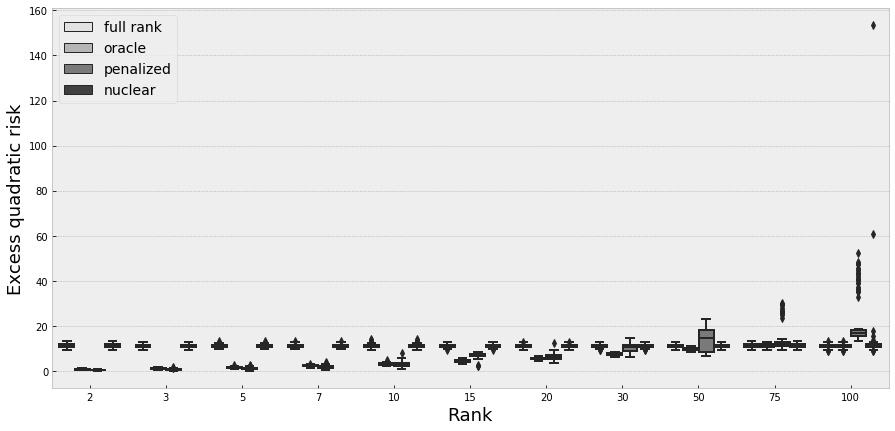

In [112]:
import seaborn as sns
plt.figure(figsize=(15,7))
plt.style.use('bmh')
ax = sns.boxplot(data=df_l,hue = 'level_1', x='rank',y= 0, palette='Greys')
#ax.set_title('Excess quadratic risk for lambda = ' +str(title[0]) +' and n = ' + str(n), fontsize = fontsize)
ax.set_xlabel('Rank', fontsize = fontsize)
ax.set_ylabel('Excess quadratic risk', fontsize = fontsize)
ax.legend(fontsize =fontsize-4)
plt.show()

In [113]:
df_l.to_csv('Save_n='+ str(n_list[i_n]) +'_M=' + str(M) + '_' + str(list_alpha[i_alpha]) + '_v2.csv')

IndexError: list index out of range

In [114]:
latex_tab = df_l.groupby(['level_1','rank']).mean().unstack().to_latex(float_format="%.2f")
print(latex_tab)

\begin{tabular}{lrrrrrrrrrrr}
\toprule
{} & \multicolumn{11}{l}{0} \\
rank &   2   &   3   &   5   &   7   &   10  &   15  &   20  &   30  &   50  &   75  &   100 \\
level\_1   &       &       &       &       &       &       &       &       &       &       &       \\
\midrule
full rank & 11.27 & 11.10 & 10.98 & 11.06 & 11.22 & 11.13 & 11.09 & 11.15 & 11.24 & 11.30 & 11.21 \\
nuclear   & 11.27 & 11.10 & 10.98 & 11.06 & 11.21 & 11.13 & 11.09 & 11.15 & 11.24 & 11.30 & 13.17 \\
oracle    &  0.72 &  1.07 &  1.66 &  2.26 &  3.14 &  4.35 &  5.51 &  7.36 &  9.81 & 11.13 & 11.21 \\
penalized &  0.46 &  0.63 &  1.04 &  1.77 &  2.95 &  6.82 &  6.28 & 10.33 & 13.60 & 13.79 & 22.37 \\
\bottomrule
\end{tabular}



We observe that the perfomance of the full rank regression doesn't seem to be affected by the rank of the underlying matrices. Low rank regression perfoms faster than the other regression and better when the underlying rank of matrix are small.

## References

[1] Birge, L. and Massart, P. (2006). Minimal penalties for gaussian model selection.
Probability Theory and Related Fields, 138(1-2):33{73.

[2]  Negahban, Sahand and Wainwright, Martin J. (2011) Estimation of (near) low-rank matrices with noise and high-dimensional scaling. The Annals of Statistics

[3] Ji, Shuiwang & Ye, Jieping. (2009). An accelerated gradient method for trace norm minimization. Proceedings of the 26th International Conference On Machine Learning, ICML 2009. 58. 10.1145/1553374.1553434. 

In [76]:
from copy import deepcopy

old_rep = deepcopy(reponses)
old_rep

[[[array([[102.28526148,   6.61440554,   3.04926719,  98.21878847],
          [104.5833145 ,   8.00044895,   3.57800797, 102.42418741],
          [ 97.61958922,   7.91532835,   3.36575205,  95.82516172],
          [ 97.71251714,   9.11838336,   4.01993447,  95.1034161 ],
          [103.85169032,   7.67681284,   4.56780015, 101.18390326],
          [101.69910875,   7.68127193,   4.29194549,  98.81609662],
          [103.74279542,   9.8332906 ,   4.93368017, 101.36474923],
          [103.67622369,   7.26326766,   3.83309138, 100.0285408 ],
          [105.17527275,   6.02318625,   3.54862451, 103.37174878],
          [103.95879972,   6.77896542,   3.86144393,  99.25246091],
          [101.67897757,   6.72398967,   3.54161064,  98.68982416],
          [113.96655741,  11.29284939,   5.45321545, 107.97821741],
          [106.01149589,   8.1042543 ,   3.64471161, 102.47266801],
          [ 96.07260069,   6.72730585,   3.21324484,  93.61951699],
          [103.31512625,   5.19504005,   2.72226

In [109]:
reponses = old_rep